# Ingesting pageview data

In this exercise, you create an HTTP endpoint that ingests page view data (clicks) into the platform. Every time a user clicks on a link and when the user scrolls to certain positions on the page, a json "click" objects gets sent to this endpoint.

```json
{
    "visitor_platform": "mobile",
    #
    # Timestamp of the event (milliseconds since unix epoch)
    "ts_ingest": 1515819844345,
    
    "article_title": "Cercanías San Sebastián",
    "visitor_country": "BE",
    
    # Seconds the page was open before this event was sent.
    # (0 when this event is sent immediately after the page was opened.)
    "visitor_page_timer": 0,

    "visitor_os": "ios",
    "article": "https://en.wikipedia.org/wiki/Cercan%C3%ADas_San_Sebasti%C3%A1n",
    
    # How much the user scrolled before this event was sent.
    # (0 when this event is sent while the user hasn't scrolled yet.)
    "visitor_page_height": 0,
    
    "visitor_browser": "unknown"
}
```


We use the [Python Flask framework](http://flask.pocoo.org/) to create the ingest HTTP endpoint. Flask is a lightweight and simple, but very powerful framework to write HTTP webservers in Python. Flask powers the api's of many large web services such as [Netflix](https://medium.com/netflix-techblog/python-at-netflix-bba45dae649e), [Airbnb](https://medium.com/airbnb-engineering/airflow-a-workflow-management-platform-46318b977fd8), [Uber](https://github.com/uber/clay) and [Reddit](https://stackshare.io/reddit/reddit).

The clicks that our API recieves are stored in [Apache Kafka](https://kafka.apache.org/), a distributed streaming platform initially created by LinkedIn. Kafka stores large distributed queues, called *topics* and allows *producers* to send data to the queue and *consumers* to read data from the queue, all in a fault-tolerant and durable way.

The sole responsibility of the Ingest API is to recieve click events from HTTP POST requests and put them on the `clicks` topic in Kafka. The Ingest API itself doesn't do any cleaning or filtering, this happens later in the pipeline. Using Kafka here has a number of advantages.

* Kafka acts as a **buffer** between the ingest of events and the processing events. Downstream issues, such as the processing code crashing, don't affect the ingest of events. This also allows the platform to **gracefully handle spikes in load**. When the processing code can't handle the load, Kafka will gather a backlog of unprocessed events, but the events will not be lost and the processing code can catch up when the load decreases again.
* Kafka allows multiple consumers to subscribe to the same topic. This makes it easy to have **multiple paralell processing pipelines** which recieve the same event stream. You can use this to run multiple versions of your code next to each other in order to do tests or quality assurance. Or to have a staging environment that recieves the same event stream as the production environment.
* Kafka is a **language-agnostic** platform with many client libraries so you can use it to create heterogenous streaming analytics pipelines.

In [1]:
%%bash
# Install the required Python 3 dependencies
python3 -m pip install kafka-python flask



# Flask introduction

The following code snippet is everything you need to get a working "Hello World" HTTP api. You start the server by running the cell. (select the cell with the python code and press `ctrl`-`enter`).

You can test the server using the `curl` command in a terminal.

```txt
$ curl http://localhost:5000
Index Page
$ curl http://localhost:5000/hello
Hello, World
```

You stop the server by clicking on the "stop" button on the toolbar of this notebook.
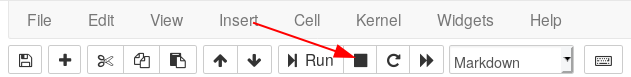

In [6]:
from flask import Flask
app = Flask(__name__)


@app.route('/')
def index():
    return 'Index Page\n'

@app.route('/hello')
def hello():
    return 'Hello, World\n'

if __name__ == "__main__":
    app.run(host='0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


## Basic functionality

* The ` @app.route("/")` annotation is used to define the URL that executes a function. In the previous example, any call to `localhost:5000/` will run the `index` function.
* You can use the variable `request` inside of such a function to get information about the request. For example, `request.json` is a dictionary generated from the `json` body of the request.

Take a look at the [Flask docs](http://flask.pocoo.org/docs/1.0/quickstart/#routing) for more information.


# Kafka Python

Below is an example for how to publish data to kafka using Python.

Take a look at the [`python-kafka` docs ](https://kafka-python.readthedocs.io/en/master/usage.html) for more information.

In [39]:
from kafka import KafkaConsumer, TopicPartition

topic ="test-topic"

producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'])

# Note: The data you send must be binary
producer.send(topic, b"Hello World!").get(timeout=30)

# To consume latest messages and auto-commit offsets
consumer = KafkaConsumer(
    group_id='test-group',
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    consumer_timeout_ms=500) # Stop iteration if no message after 5sec
tp = TopicPartition(topic,0)
consumer.assign([tp])

consumer.seek(tp, 0)         # Go to the beginning of the queue


for message in consumer:
    # message value and key are raw bytes -- decode if necessary!
    # e.g., for unicode: `message.value.decode('utf-8')`
    print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition,
                                          message.offset, message.key,
                                          message.value))

test-topic:0:0: key=None value=b'test-data'
test-topic:0:1: key=None value=b'test-data'
test-topic:0:2: key=None value=b'test-data'
test-topic:0:3: key=None value=b'test-data'
test-topic:0:4: key=None value=b'test-data'
test-topic:0:5: key=None value=b'test-data'
test-topic:0:6: key=None value=b'test-data'
test-topic:0:7: key=None value=b'test-data'
test-topic:0:8: key=None value=b'test-data'
test-topic:0:9: key=None value=b'test-data'
test-topic:0:10: key=None value=b'test-data'
test-topic:0:11: key=None value=b'test-data'
test-topic:0:12: key=None value=b'test-data'


# Endpoint API

> **Task:** Write a server that listens for `POST` requests to the url `/clicks`, reads the body of the request as `json`, and sends sends that body to the `clicks` topic on Kafka.

You can use the [fake-website](fake-website.ipynb) notebook to simulate three hours of pageview data.

In [40]:
import json
import datetime
import uuid
import re
import os
from flask import Flask, request, Response, send_file, send_from_directory
from kafka import KafkaProducer

app = Flask(__name__, static_url_path='')

class Producer(object):
    def __init__(self):
        self.producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                                      value_serializer=lambda v: json.dumps(v).encode('utf-8'))

    def produce(self, topic, data):
        self.producer.send(topic, data).get(timeout=30)


producer = Producer()
i = 0


'''
/clicks [POST]
-----

'''
@app.route('/clicks', methods=['POST'])
def extranm():
    global i
    if i > 1000:
        clear_output()
        i = 0
    i = i+1
    
    rjson = request.json
    
    if not rjson:
        return json.dumps({'success':False, 'message': 'could not decode json'}), 400, {'ContentType':'application/json'}

    producer.produce('clicks', rjson)
    return json.dumps({'success':True}), 200, {'ContentType':'application/json'}



if __name__ == "__main__":
    app.run(host='0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
